# Momentum Risk Parity
- การผสมผสานระหว่าง Momentum กับการจัดสรรน้ำหนักแบบ Risk Parity

In [500]:
import sys
import os
from IPython.display import display, HTML 
%config InlineBackend.figure_format='retina'

# กำหนด path ไปยังโฟลเดอร์ 'libs' ที่อยู่ข้างนอกของ 'subfolder'
# ใช้ os.path.abspath สำหรับการรับ absolute path
libs_path = os.path.abspath(os.path.join(os.getcwd(), '../..', ''))

# ใส่ path นี้ไปที่ตำแหน่งแรกใน sys.path เพื่อให้ Python ค้นหาที่นี่ก่อน
if libs_path not in sys.path:
    sys.path.insert(0, libs_path)

import starfishXapi as sx
from starfishXapi.set_api import fnType
from starfishXapi.set_api import indexType
sx.enable_autoreload()
print(sx.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Autoreload enabled.
0.00104


In [423]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%config InlineBackend.figure_format='retina'

import time # wait สำหรับการดึงข้อมูล

import scipy.optimize as sco # ใช้ตอน optimize น้ำหนักการลงทุน

<b>Momentum Risk Parity Strategy</b><br>
ขบวนการ<br>
1.คัดเลือกหุ้นที่ต้องการมา 1 ชุดอาจจะ 10-20 ตัวตามต้องการ<br>
2.ใช้ momentum ของหุ้นในการคัดกรองมา 5 หุ้น<br>
<span>&nbsp;&nbsp;-ตัวอย่างนี้เลือกใช้ relative strength rating ของ william O’Neil เป็น momentum </span>
  
3.ใช้ risk parity ในการจัดสรรน้ำหนัก<br>
4.ลงทุนตามหุ้น 5 ตัวและจัดสรรน้ำหนักตาม risk parity<br>
5.ตรวจสอบการคงอยู่ momentum ของหุ้นทุกๆ 3 เดือนและทำซ้ำข้อ 2-4<br>

In [334]:
# 1️⃣ สินทรัพย์ที่คุณสนใจ N ตัว และช่วงเวลาทดสอบ
''' basket = ['KCE','INTUCH','CHG','ILM','TVH','AURA','DUSIT','HL',
          'SFLEX','TKN','JMART','MGI','SABINA','ERW','BTG','SYMC','RBF',
          'SPALI','MC','BLC'] '''

basket = sx.get_member_of_index(indexType.set50)['symbol']
basket = list(basket)

basket = basket + ['SET'] # เปรียบเทียบตลาด
basket = list(set(basket))

In [335]:
# สร้าง object dataReader
dataReader = sx.HistStockPrice()
dataReader.openLog(directory='cache/') # สร้าง folder cache/

False

In [336]:
start_date = '2023-10-01'
stop_date = '2024-09-26'  

t_test = 3 # month

folder = 'cache/'

# preprocess data Load to Cache
t_try=0
while(1):
  if(t_try>3):
    break  
  c = 0  
  try:  
    for i in basket:
      c+=1  
      print(i,end=',')    
      df = dataReader.getPrice(i,start=start_date,stop=stop_date,cache=True) # สำรองข้อมูลลง cache  
  except:
    time.sleep(3)
    print('try again')  
    t_try+=1  
  if(c==len(basket)):
     break 

WHA,TLI,TRUE,HMPRO,EA,KTB,BCP,CENTEL,TTB,SCB,TU,CPALL,BEM,OR,KBANK,MTC,PTT,TOP,KTC,PTTEP,OSP,SCC,TISCO,ITC,PTTGC,BJC,LH,SET,CPF,AOT,BDMS,CPN,GPSC,RATCH,INTUCH,BTS,CBG,SCGP,BGRIM,IVL,AWC,GULF,ADVANC,MINT,TIDLOR,BBL,GLOBAL,CRC,DELTA,EGCO,BH,

In [337]:
start_date = '2022-10-01'
stop_date = '2024-09-26'  

t_test = 3 # month

folder = 'cache/'

# preprocess data Load to Cache
t_try=0
while(1):
  if(t_try>3):
    break  
  c = 0  
  try:  
    for i in basket:
      c+=1  
      print(i,end=',')    
      df = dataReader.getPrice(i,start=start_date,stop=stop_date,cache=True) # สำรองข้อมูลลง cache   
  except:
    time.sleep(3)
    print('try again')  
    t_try+=1  
  if(c==len(basket)):
     break 

WHA,TLI,TRUE,HMPRO,EA,KTB,BCP,CENTEL,TTB,SCB,TU,CPALL,BEM,OR,KBANK,MTC,PTT,TOP,KTC,PTTEP,OSP,SCC,TISCO,ITC,PTTGC,BJC,LH,SET,CPF,AOT,BDMS,CPN,GPSC,RATCH,INTUCH,BTS,CBG,SCGP,BGRIM,IVL,AWC,GULF,ADVANC,MINT,TIDLOR,BBL,GLOBAL,CRC,DELTA,EGCO,BH,

In [340]:
m = []
for i in basket:  
 k = dataReader.getPrice(i,start=start_date,stop=stop_date,cache=True) 
 k = k[['close']]
 k.columns = [i]   
 m.append(k) 

df = pd.concat(m,axis=1)

In [341]:
df = df.sort_index() # ให้มั่นใจว่าเรียงลำดับแล้ว
df.head(5)

WHA   TLI  TRUE  HMPRO     EA   KTB    BCP  CENTEL   TTB    SCB  \
Date                                                                           
2022-10-03  3.42  15.6   NaN   13.2  86.00  16.5  29.75   46.75  1.19  102.0   
2022-10-04  3.46  15.3   NaN   13.5  86.25  16.7  30.00   49.25  1.20  103.5   
2022-10-05  3.48  15.3   NaN   13.6  87.25  16.9  30.25   50.00  1.20  104.0   
2022-10-06  3.50  15.5   NaN   13.6  87.50  16.9  31.00   49.50  1.22  105.0   
2022-10-07  3.56  15.1   NaN   13.6  88.00  16.9  30.75   50.50  1.22  105.0   

            ...   GULF  ADVANC   MINT     TIDLOR    BBL     GLOBAL    CRC  \
Date        ...                                                             
2022-10-03  ...  50.50   192.0  26.25  22.500009  132.5  17.815376  38.00   
2022-10-04  ...  51.00   193.0  26.75  22.714295  135.0  17.723068  39.75   
2022-10-05  ...  50.00   190.0  27.50  22.928581  136.5  17.538453  39.50   
2022-10-06  ...  49.75   186.5  27.50  23.357152  138.0  17.815376  39.50   
2022-10-07  ...  49.25   186.5  27.00  22.500009  138.0  17.630761  39.25   

            DELTA   EGCO     BH  
Date                             
2022-10-03   62.0  163.0  222.0  
2022-10-04   66.8  161.0  229.0  
2022-10-05   66.6  165.0  229.0  
2022-10-06   70.0  163.0  233.0  
2022-10-07   65.8  162.0  233.0  

[5 rows x 51 columns]

In [343]:
# 2️⃣ ใช้ momentum ของหุ้นในการคัดกรองมา 5 หุ้น

In [344]:
df['Quarter'] = pd.PeriodIndex(df.index, freq='Q')

In [346]:
T_P = df.groupby('Quarter').size()
T_P

Quarter
2022Q4    60
2023Q1    63
2023Q2    58
2023Q3    62
2023Q4    60
2024Q1    63
2024Q2    57
2024Q3    61
Freq: Q-DEC, dtype: int64

## คัดกรอง momentum

In [348]:
# ทดสอบการคัดกรองด้วย momentum
def relative_strength_rating(m):
  m = m.dropna(axis=1, how='any') # ลบคอลัมน์ที่มีค่า NaN อย่างน้อย 1 ค่า (ถ้าใช้ how='all' จะลบเฉพาะคอลัมน์ที่ทุกค่าเป็น NaN)
  m = m.drop(columns='Quarter')

  start_date_T = m.index[0]
  stop_date_T =  m.index[-1] 

  SETBegin = m[m.index==start_date_T]['SET'].values[0]
  SETEnd = m[m.index==stop_date_T]['SET'].values[0]

  RS = (m[m.index==stop_date_T].values / m[m.index==start_date_T].values)    /    (SETEnd/SETBegin)
  RS = pd.DataFrame({'RS':RS[0]},index=m.columns)

  RS = sx.rankWithRange(data=RS,minScope=1,maxScope=99)
  return RS.head(5)


# Function to calculate portfolio risk
def portfolio_risk(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Function to calculate risk contribution of each asset
def risk_contribution(weights, cov_matrix):
    port_risk = portfolio_risk(weights, cov_matrix)
    marginal_contrib = np.dot(cov_matrix, weights)
    return weights * marginal_contrib / port_risk

# Function to calculate percentage risk contribution
def percentage_risk_contribution(weights, cov_matrix):
    total_risk = portfolio_risk(weights, cov_matrix)
    marginal_contrib = np.dot(cov_matrix, weights)
    risk_contributions = weights * marginal_contrib / total_risk
    return 100 * risk_contributions / total_risk  # Convert to percentage

# Adjust the objective function to make sure it's minimizing the absolute difference between risk contributions
def risk_parity_objective(weights, cov_matrix):
    risk_contribs = risk_contribution(weights, cov_matrix)
    return np.sum(np.abs(risk_contribs - risk_contribs.mean()))  # Minimize absolute differences

In [350]:
bsq = [] # basket ในแต่ละไตรมาส
for i in T_P.index:
   q = []  
   m = df[df['Quarter'] == i]
   r = relative_strength_rating(m)
   print(i,end=' ') 
   for j in r.index:
     print(j,end=',')  
     q.append(j)  
   print()    
   bsq.append(q) 

2022Q4 DELTA,CPALL,MINT,CRC,BGRIM,
2023Q1 DELTA,CENTEL,BJC,ADVANC,OSP,
2023Q2 KTB,MTC,BCP,TTB,PTT,
2023Q3 CBG,BH,WHA,TU,BCP,
2023Q4 MTC,PTTGC,CPN,GPSC,TIDLOR,
2024Q1 TRUE,AWC,MINT,TOP,BCP,
2024Q2 CPF,SCGP,ITC,TRUE,DELTA,
2024Q3 GULF,TLI,DELTA,INTUCH,TRUE,


## คำนวณน้ำหนัก risk parity 

In [356]:
# 3️⃣ ใช้ risk parity ในการจัดสรรน้ำหนัก
# ดูอย่างตัวอย่างที่ 
# https://tapattan.gitlab.io/python/starfishXapi/workshop/RiskParity.html

report = []
for i in range(len(T_P.index)):
    df_q = df[df['Quarter'] == T_P.index[i]][bsq[i]]
    
    n_assets = 5
    weights = np.ones(n_assets) / n_assets
    initial_weights = weights
    
    # Bounds for weights: between 0 and 1
    bounds = tuple((0, 1) for asset in range(n_assets))
    
    # Constraints: sum of weights must be 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    
    cov_matrix = df_q.cov()
    
    pct_rcVbefore = percentage_risk_contribution(weights,cov_matrix)
    
    # Re-run the optimization using the adjusted objective function
    opt_results_adjusted = sco.minimize(risk_parity_objective, initial_weights, args=(cov_matrix,), 
                                        method='SLSQP', bounds=bounds, constraints=constraints)
    
    optimal_weights_adjusted = opt_results_adjusted.x
    
    # Recalculate risk contribution using the new optimal weights
    final_percentage_risk_contribution_adjusted = percentage_risk_contribution(optimal_weights_adjusted, cov_matrix)
    
    
    # สร้าง DataFrame แสดงผล
    rc_df = pd.DataFrame({
        'Asset': df_q.columns,
        'Weight': weights,
        'Risk Contribution(%)': pct_rcVbefore,
        'Optimal Weights':optimal_weights_adjusted,
        'Otpimal Risk Contribution(%)':final_percentage_risk_contribution_adjusted,
        'Priod':[str(T_P.index[i])]*len(df_q.columns)
    })

    report.append(rc_df)

report = pd.concat(report,ignore_index=True)
report.head(5)

Asset  Weight  Risk Contribution(%)  Optimal Weights  \
0  DELTA     0.2             27.369407         0.143198   
1  CPALL     0.2             25.818030         0.140518   
2   MINT     0.2             12.788764         0.278904   
3    CRC     0.2             14.314683         0.254439   
4  BGRIM     0.2             19.709116         0.182941   

   Otpimal Risk Contribution(%)   Priod  
0                     19.999606  2022Q4  
1                     20.000108  2022Q4  
2                     20.000276  2022Q4  
3                     20.000022  2022Q4  
4                     19.999989  2022Q4

## การวัดผล

In [360]:
# Portfolio Return
# 4️⃣ + 5️⃣ คำนวณการลงทุนตามน้ำหนักและหมุนเวียนตาม momentum

k = 0
for i in range(len(T_P.index)-1):
    asset = df[df['Quarter'] == T_P.index[i+1]][bsq[i]] # *** เอาหุ้นใน Q นี้ ไปใช้กับผลตอบแทน Q ถัดไป ***
    asset = asset/asset.iloc[0] #rebase 100

    w = report[report['Priod']==str(T_P.index[i])]['Optimal Weights']
    if(k==0): 
      report_port = list(np.dot(asset, w))
      report_port_eq = list(np.dot(asset, initial_weights)) # initial_weights = [0.2]*5
    else:      
      rr = list(np.dot(asset, w)+report_port[-1]-1) # *** ต่อยอดผลตอบแทนที่ได้มาใน Q ก่อนหน้า ***
      report_port = report_port + rr

      rr_eq = list(np.dot(asset, initial_weights)+report_port_eq[-1]-1)
      report_port_eq = report_port_eq + rr_eq 
      
    k+=1  

In [361]:
def report_rank():
    bsq = [] # basket ในแต่ละไตรมาส
    # ผู้นำใน rank ที่นำมาหาผลตอบแทน
    for i in T_P.index:
       q = []  
       m = df[df['Quarter'] == i]
       r = relative_strength_rating(m)  #ใช้ relative strength rating ของ william O’Neil เป็น momentum
       print(i,end=' ') 
       for j in r.index:
         print(j,end=',')  
         q.append(j)  
       print()    
       bsq.append(q) 

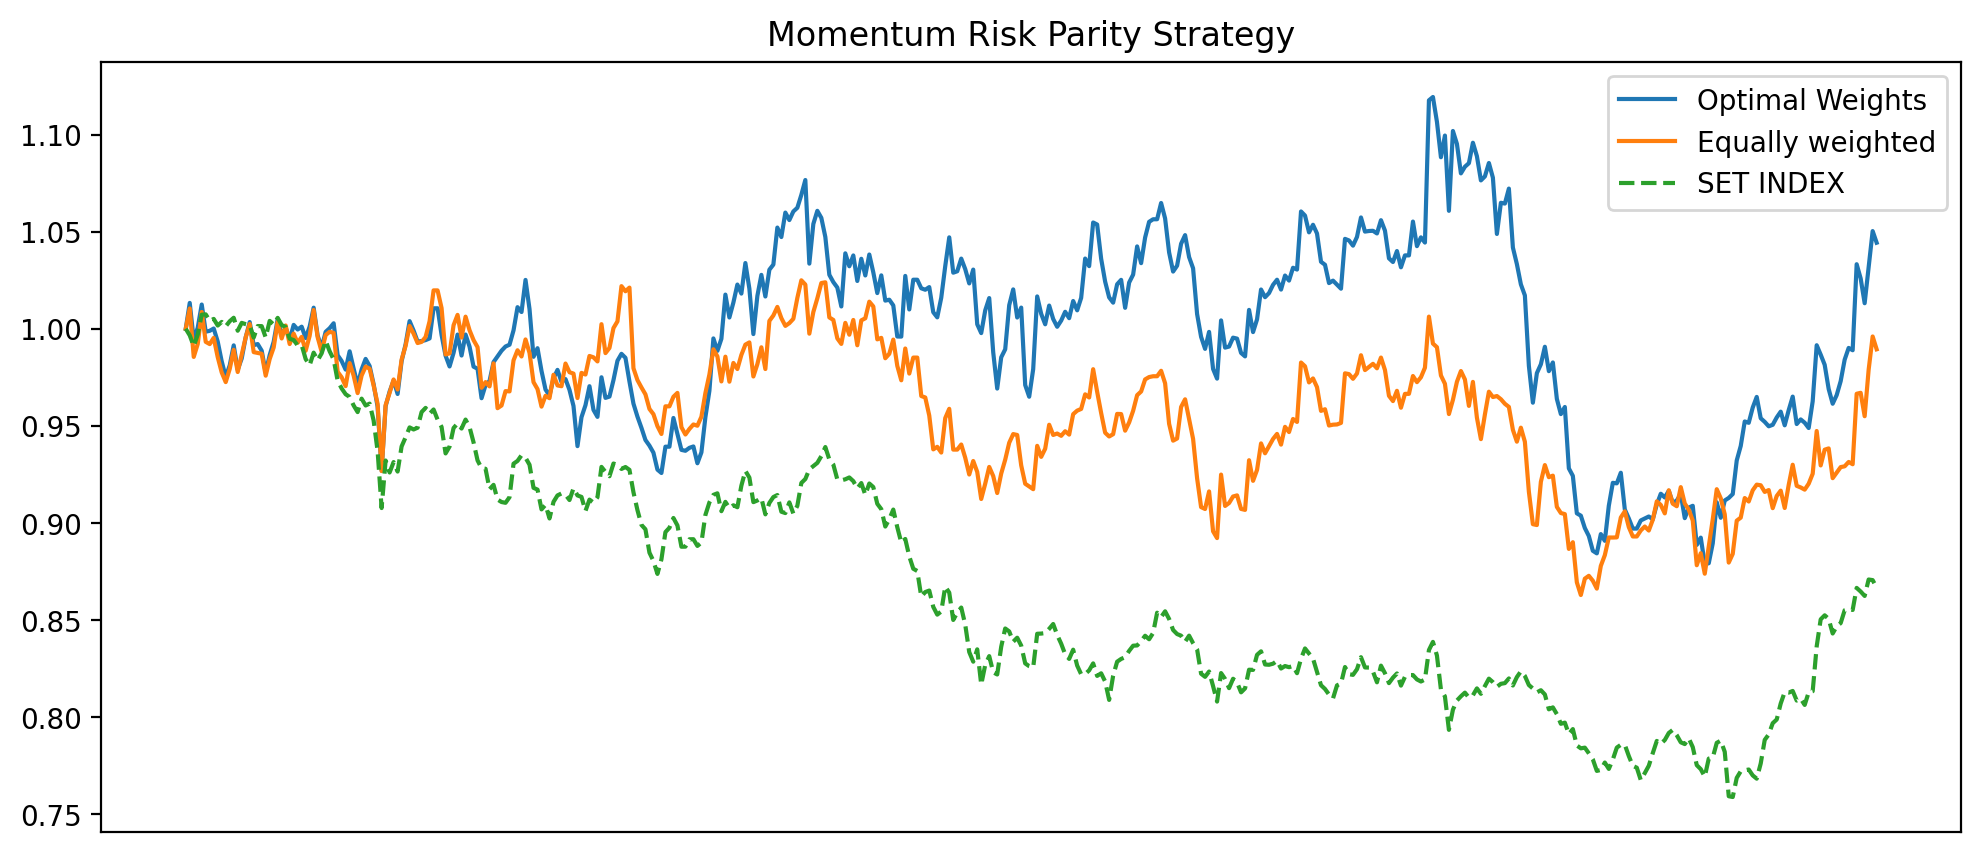

In [362]:
plt.subplots(figsize=(12,5))
report_port = np.array(report_port)
y = report_port#.cumsum()
plt.title('Momentum Risk Parity Strategy')
plt.plot(report_port,label='Optimal Weights')
plt.plot(report_port_eq,label='Equally weighted')

b = df[df['Quarter']!=df['Quarter'].iloc[0]]['SET']
b = b/b.iloc[0]
plt.plot(b,label='SET INDEX',linestyle='--')
plt.legend()
plt.xticks([])
plt.show()

In [363]:
report_rank()

2022Q4 DELTA,CPALL,MINT,CRC,BGRIM,
2023Q1 DELTA,CENTEL,BJC,ADVANC,OSP,
2023Q2 KTB,MTC,BCP,TTB,PTT,
2023Q3 CBG,BH,WHA,TU,BCP,
2023Q4 MTC,PTTGC,CPN,GPSC,TIDLOR,
2024Q1 TRUE,AWC,MINT,TOP,BCP,
2024Q2 CPF,SCGP,ITC,TRUE,DELTA,
2024Q3 GULF,TLI,DELTA,INTUCH,TRUE,


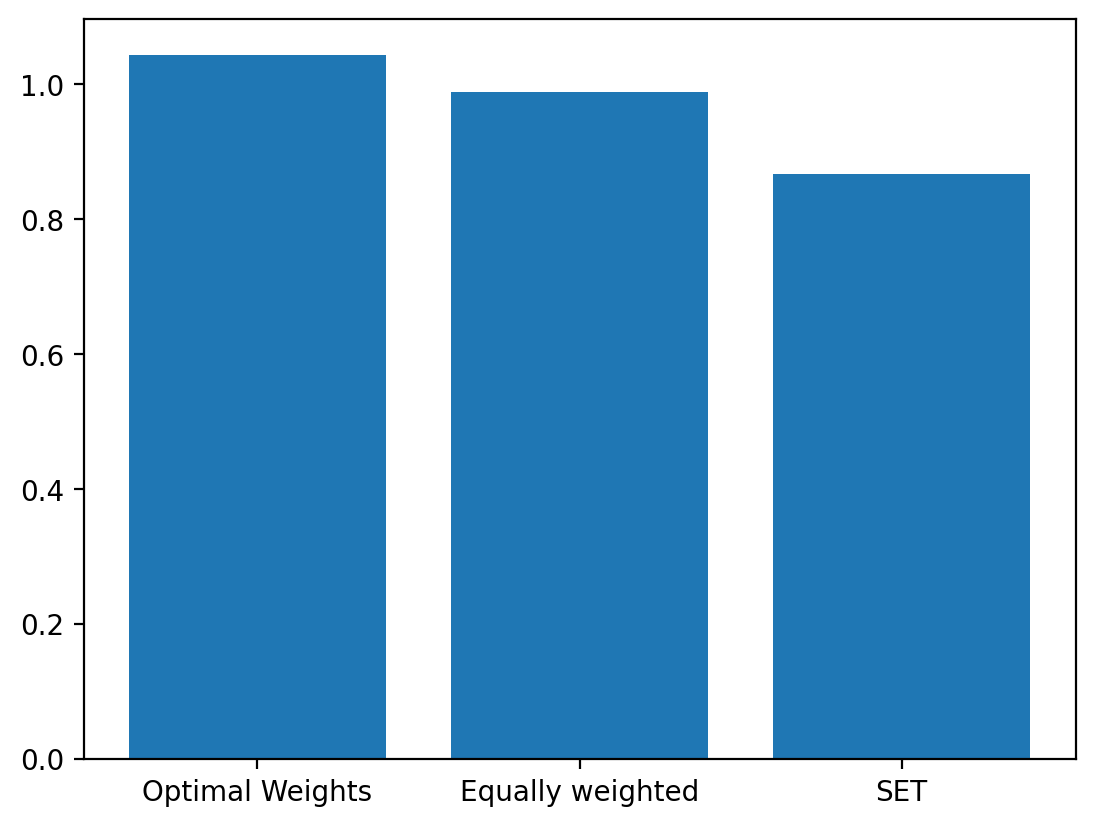

In [364]:
k = pd.DataFrame({'Optimal Weights':report_port,'Equally weighted':report_port_eq,'SET':b})
plt.bar(x=k.columns,height=k.tail(1).values[0])
plt.show()

## Practice
- แบบฝึกหัด Momentum Risk Parity ทดสอบการกับหุ้นอเมริกา 
- สมมติ basket ดังนี้ META AAPL AMZN MSFT GOOG NVDA TSM CRM AVGO ORCL COST UNH MRK LLY XAUUSD
- Momentum ที่ Rank ดีสุด
- Reblance ทุก 3 เดือน

<br>
1️⃣.คัดเลือกหุ้นที่ต้องการมา 1 ชุดอาจจะ 10-20 ตัวตามต้องการ <br>
2️⃣.ใช้ momentum ของหุ้นในการคัดกรองมา 5 หุ้น<br>
  -ตัวอย่างนี้เลือกใช้ relative strength rating ของ william O’Neil เป็น momentum <br>
<br>

3️⃣.ใช้ risk parity ในการจัดสรรน้ำหนัก<br>
4️⃣.ลงทุนตามหุ้น 5 ตัวและจัดสรรน้ำหนักตาม risk parity<br>
5️⃣.ตรวจสอบการคงอยู่ momentum ของหุ้นทุกๆ 3 เดือนและทำซ้ำข้อ 2-4<br>

In [437]:
# 1️⃣ คัดเลือกหุ้นที่ต้องการมา 1 ชุดอาจจะ 10-20 ตัวตามต้องการ

basket   = ['META','AAPL','AMZN','MSFT','GOOG','NVDA','TSM','CRM','AVGO','ORCL','COST','UNH','MRK','LLY','XAUUSD']
exchange = ['nasdaq','nasdaq','nasdaq','nasdaq','nasdaq','nasdaq','nyse','nyse','nasdaq','nyse','nasdaq','nyse','nyse','nyse','oanda']

basket = basket + ['SPX']
exchange = exchange + ['sp']

for i,j in zip(basket,exchange):
  print(i,j)

len(basket),len(exchange)

META nasdaq
AAPL nasdaq
AMZN nasdaq
MSFT nasdaq
GOOG nasdaq
NVDA nasdaq
TSM nyse
CRM nyse
AVGO nasdaq
ORCL nyse
COST nasdaq
UNH nyse
MRK nyse
LLY nyse
XAUUSD oanda
SPX sp


(16, 16)

In [439]:
# สร้าง object dataReader
dataReader = sx.HistStockPrice()
dataReader.openLog(directory='cache_usa/') # สร้าง folder cache/

False

In [441]:
#basket.pop(-2)
#exchange.pop(-2)

In [442]:
start_date = '2020-10-01'
stop_date = '2024-10-18'  

t_test = 3 # month

folder = 'cache_usa/'

# preprocess data Load to Cache
t_try=0
while(1):
  if(t_try>3):
    break  
  c = 0  
  try:  
    for i,j in zip(basket,exchange):
      print(i,j)
      c+=1    
      df = dataReader.getPrice(i,exchange=j,start=start_date,stop=stop_date,cache=True) # สำรองข้อมูลลง cache   
        
  except:
    time.sleep(3)
    print('try again')  
    t_try+=1  
  if(c==len(basket)):
     break 

META nasdaq
AAPL nasdaq
AMZN nasdaq
MSFT nasdaq
GOOG nasdaq
NVDA nasdaq
TSM nyse
CRM nyse
AVGO nasdaq
ORCL nyse
COST nasdaq
UNH nyse
MRK nyse
LLY nyse
XAUUSD oanda
SPX sp


In [445]:
m = []
for i in basket:  
 k = dataReader.getPrice(i,start=start_date,stop=stop_date,cache=True) 
 k = k[(k.index>=start_date) & (k.index<=stop_date)]   
 k = k[['close']]
 k.columns = [i]   
 m.append(k) 

df = pd.concat(m,axis=1)
df

META    AAPL      AMZN    MSFT     GOOG      NVDA    TSM  \
Date                                                                     
2020-10-01  266.63  116.79  161.0630  212.46  74.5045  13.61450  82.62   
2020-10-02  259.94  113.02  156.2500  206.19  72.9210  13.06225  80.80   
2020-10-05  264.65  116.50  159.9600  210.38  74.3010  13.64250  84.54   
2020-10-06  258.66  113.16  154.9980  205.91  72.6720  13.73650  83.12   
2020-10-07  258.12  115.08  159.7845  209.83  73.0145  13.96400  86.92   
...            ...     ...       ...     ...      ...       ...    ...   
2024-02-19     NaN     NaN       NaN     NaN      NaN       NaN    NaN   
2024-05-27     NaN     NaN       NaN     NaN      NaN       NaN    NaN   
2024-06-19     NaN     NaN       NaN     NaN      NaN       NaN    NaN   
2024-07-04     NaN     NaN       NaN     NaN      NaN       NaN    NaN   
2024-09-02     NaN     NaN       NaN     NaN      NaN       NaN    NaN   

               CRM    AVGO   ORCL    COST     UNH        MRK     LLY  \
Date                                                                   
2020-10-01  253.45  36.860  59.68  358.46  313.07  77.845781  144.29   
2020-10-02  247.85  35.683  58.83  355.01  311.98  77.044820  145.21   
2020-10-05  251.53  36.610  59.56  358.58  318.15  77.464371  146.63   
2020-10-06  250.14  36.398  59.51  358.35  314.45  75.929196  144.13   
2020-10-07  259.98  36.674  60.59  363.02  323.17  76.320141  148.96   
...            ...     ...    ...     ...     ...        ...     ...   
2024-02-19     NaN     NaN    NaN     NaN     NaN        NaN     NaN   
2024-05-27     NaN     NaN    NaN     NaN     NaN        NaN     NaN   
2024-06-19     NaN     NaN    NaN     NaN     NaN        NaN     NaN   
2024-07-04     NaN     NaN    NaN     NaN     NaN        NaN     NaN   
2024-09-02     NaN     NaN    NaN     NaN     NaN        NaN     NaN   

              XAUUSD      SPX  
Date                           
2020-10-01  1906.120  3380.80  
2020-10-02  1899.168  3348.44  
2020-10-05  1913.445  3408.63  
2020-10-06  1878.177  3360.95  
2020-10-07  1887.592  3419.45  
...              ...      ...  
2024-02-19  2017.945      NaN  
2024-05-27  2351.375      NaN  
2024-06-19  2328.230      NaN  
2024-07-04  2357.200      NaN  
2024-09-02  2499.420      NaN  

[1046 rows x 16 columns]

In [447]:
# กรณี concat แล้วพัง ใช้ท่านี้แทน !! เพราะมีทองคำเข้ามาผสม ทำให้ dataframe ไม่สมดุล

# ใช้ loop เพื่อ join DataFrame ทั้งหมด
df = m[0]  # เริ่มจาก DataFrame แรก
for i in range(1,len(m)):  # Loop ผ่าน DataFrame ที่เหลือ
  df = df.join(m[i], how='inner')

df

META    AAPL      AMZN    MSFT      GOOG       NVDA     TSM  \
Date                                                                        
2020-10-01  266.63  116.79  161.0630  212.46   74.5045   13.61450   82.62   
2020-10-02  259.94  113.02  156.2500  206.19   72.9210   13.06225   80.80   
2020-10-05  264.65  116.50  159.9600  210.38   74.3010   13.64250   84.54   
2020-10-06  258.66  113.16  154.9980  205.91   72.6720   13.73650   83.12   
2020-10-07  258.12  115.08  159.7845  209.83   73.0145   13.96400   86.92   
...            ...     ...       ...     ...       ...        ...     ...   
2024-10-14  590.42  231.30  187.5400  419.14  166.3500  138.07000  192.21   
2024-10-15  586.27  233.85  187.6900  418.74  166.9000  131.60000  187.13   
2024-10-16  576.79  231.78  186.8900  416.12  166.7400  135.72000  187.48   
2024-10-17  576.93  232.15  187.5300  416.72  164.5100  136.93000  205.84   
2024-10-18  576.47  235.00  188.9900  418.16  165.0500  138.00000  200.78   

               CRM     AVGO    ORCL    COST     UNH         MRK     LLY  \
Date                                                                      
2020-10-01  253.45   36.860   59.68  358.46  313.07   77.845781  144.29   
2020-10-02  247.85   35.683   58.83  355.01  311.98   77.044820  145.21   
2020-10-05  251.53   36.610   59.56  358.58  318.15   77.464371  146.63   
2020-10-06  250.14   36.398   59.51  358.35  314.45   75.929196  144.13   
2020-10-07  259.98   36.674   60.59  363.02  323.17   76.320141  148.96   
...            ...      ...     ...     ...     ...         ...     ...   
2024-10-14  291.64  182.310  176.12  889.76  605.40  109.690000  929.51   
2024-10-15  288.35  175.980  174.09  894.61  556.29  111.530000  913.32   
2024-10-16  290.86  176.820  174.77  887.38  571.34  110.420000  916.42   
2024-10-17  291.11  181.530  175.68  885.29  566.03  109.750000  917.12   
2024-10-18  292.94  179.890  174.69  889.56  569.61  108.700000  917.97   

              XAUUSD      SPX  
Date                           
2020-10-01  1906.120  3380.80  
2020-10-02  1899.168  3348.44  
2020-10-05  1913.445  3408.63  
2020-10-06  1878.177  3360.95  
2020-10-07  1887.592  3419.45  
...              ...      ...  
2024-10-14  2648.785  5859.86  
2024-10-15  2662.695  5815.25  
2024-10-16  2673.930  5842.48  
2024-10-17  2693.010  5841.48  
2024-10-18  2721.900  5864.68  

[1019 rows x 16 columns]

In [449]:
df['Quarter'] = pd.PeriodIndex(df.index, freq='Q')
T_P = df.groupby('Quarter').size()
T_P

Quarter
2020Q4    64
2021Q1    61
2021Q2    63
2021Q3    64
2021Q4    64
2022Q1    62
2022Q2    62
2022Q3    64
2022Q4    63
2023Q1    62
2023Q2    62
2023Q3    63
2023Q4    63
2024Q1    61
2024Q2    63
2024Q3    64
2024Q4    14
Freq: Q-DEC, dtype: int64

In [451]:
df

META    AAPL      AMZN    MSFT      GOOG       NVDA     TSM  \
Date                                                                        
2020-10-01  266.63  116.79  161.0630  212.46   74.5045   13.61450   82.62   
2020-10-02  259.94  113.02  156.2500  206.19   72.9210   13.06225   80.80   
2020-10-05  264.65  116.50  159.9600  210.38   74.3010   13.64250   84.54   
2020-10-06  258.66  113.16  154.9980  205.91   72.6720   13.73650   83.12   
2020-10-07  258.12  115.08  159.7845  209.83   73.0145   13.96400   86.92   
...            ...     ...       ...     ...       ...        ...     ...   
2024-10-14  590.42  231.30  187.5400  419.14  166.3500  138.07000  192.21   
2024-10-15  586.27  233.85  187.6900  418.74  166.9000  131.60000  187.13   
2024-10-16  576.79  231.78  186.8900  416.12  166.7400  135.72000  187.48   
2024-10-17  576.93  232.15  187.5300  416.72  164.5100  136.93000  205.84   
2024-10-18  576.47  235.00  188.9900  418.16  165.0500  138.00000  200.78   

               CRM     AVGO    ORCL    COST     UNH         MRK     LLY  \
Date                                                                      
2020-10-01  253.45   36.860   59.68  358.46  313.07   77.845781  144.29   
2020-10-02  247.85   35.683   58.83  355.01  311.98   77.044820  145.21   
2020-10-05  251.53   36.610   59.56  358.58  318.15   77.464371  146.63   
2020-10-06  250.14   36.398   59.51  358.35  314.45   75.929196  144.13   
2020-10-07  259.98   36.674   60.59  363.02  323.17   76.320141  148.96   
...            ...      ...     ...     ...     ...         ...     ...   
2024-10-14  291.64  182.310  176.12  889.76  605.40  109.690000  929.51   
2024-10-15  288.35  175.980  174.09  894.61  556.29  111.530000  913.32   
2024-10-16  290.86  176.820  174.77  887.38  571.34  110.420000  916.42   
2024-10-17  291.11  181.530  175.68  885.29  566.03  109.750000  917.12   
2024-10-18  292.94  179.890  174.69  889.56  569.61  108.700000  917.97   

              XAUUSD      SPX Quarter  
Date                                   
2020-10-01  1906.120  3380.80  2020Q4  
2020-10-02  1899.168  3348.44  2020Q4  
2020-10-05  1913.445  3408.63  2020Q4  
2020-10-06  1878.177  3360.95  2020Q4  
2020-10-07  1887.592  3419.45  2020Q4  
...              ...      ...     ...  
2024-10-14  2648.785  5859.86  2024Q4  
2024-10-15  2662.695  5815.25  2024Q4  
2024-10-16  2673.930  5842.48  2024Q4  
2024-10-17  2693.010  5841.48  2024Q4  
2024-10-18  2721.900  5864.68  2024Q4  

[1019 rows x 17 columns]

In [453]:
# 2️⃣ ทดสอบการคัดกรองด้วย momentum
def relative_strength_rating(m):
  m = m.dropna(axis=1, how='any') # ลบคอลัมน์ที่มีค่า NaN อย่างน้อย 1 ค่า (ถ้าใช้ how='all' จะลบเฉพาะคอลัมน์ที่ทุกค่าเป็น NaN)
  m = m.drop(columns='Quarter')

  start_date_T = m.index[0]
  stop_date_T =  m.index[-1] 
  #print(m)
  SETBegin = m[m.index==start_date_T]['SPX'].values[0]
  SETEnd = m[m.index==stop_date_T]['SPX'].values[0]
  #print(1)

  RS = (m[m.index==stop_date_T].values / m[m.index==start_date_T].values)    /    (SETEnd/SETBegin)
  RS = pd.DataFrame({'RS':RS[0]},index=m.columns)

  RS = sx.rankWithRange(data=RS,minScope=1,maxScope=99)
  return RS.head(5)

In [455]:
bsq = [] # basket ในแต่ละไตรมาส
for i in T_P.index:
   print(i) 
   q = []  
   m = df[df['Quarter'] == i]
   r = relative_strength_rating(m)
   print(i,end=' ') 
   for j in r.index:
     print(j,end=',')  
     q.append(j)  
   print()    
   bsq.append(q) 

2020Q4
2020Q4 TSM,AVGO,GOOG,LLY,AAPL,
2021Q1
2021Q1 GOOG,LLY,ORCL,META,AVGO,
2021Q2
2021Q2 NVDA,LLY,GOOG,META,MSFT,
2021Q3
2021Q3 COST,CRM,ORCL,GOOG,MSFT,
2021Q4
2021Q4 NVDA,AVGO,UNH,COST,AAPL,
2022Q1
2022Q1 XAUUSD,MRK,LLY,COST,UNH,
2022Q2
2022Q2 LLY,MRK,UNH,XAUUSD,ORCL,
2022Q3
2022Q3 AMZN,LLY,AAPL,UNH,COST,
2022Q4
2022Q4 ORCL,MRK,AVGO,NVDA,LLY,
2023Q1
2023Q1 NVDA,META,CRM,AAPL,TSM,
2023Q2
2023Q2 NVDA,AVGO,META,LLY,AMZN,
2023Q3
2023Q3 LLY,GOOG,UNH,META,COST,
2023Q4
2023Q4 AVGO,CRM,TSM,AMZN,MSFT,
2024Q1
2024Q1 NVDA,META,TSM,LLY,AVGO,
2024Q2
2024Q2 NVDA,AAPL,TSM,LLY,AVGO,
2024Q3
2024Q3 ORCL,UNH,META,XAUUSD,AAPL,
2024Q4
2024Q4 NVDA,TSM,CRM,AVGO,ORCL,


In [457]:
# 3️⃣ ใช้ risk parity ในการจัดสรรน้ำหนัก
# ดูอย่างตัวอย่างที่ 
# https://tapattan.gitlab.io/python/starfishXapi/workshop/RiskParity.html

report = []
for i in range(len(T_P.index)):
    df_q = df[df['Quarter'] == T_P.index[i]][bsq[i]]
    
    n_assets = 5
    weights = np.ones(n_assets) / n_assets
    initial_weights = weights
    
    # Bounds for weights: between 0 and 1
    bounds = tuple((0, 1) for asset in range(n_assets))
    
    # Constraints: sum of weights must be 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    
    cov_matrix = df_q.cov()
    
    pct_rcVbefore = percentage_risk_contribution(weights,cov_matrix)
    
    # Re-run the optimization using the adjusted objective function
    opt_results_adjusted = sco.minimize(risk_parity_objective, initial_weights, args=(cov_matrix,), 
                                        method='SLSQP', bounds=bounds, constraints=constraints)
    
    optimal_weights_adjusted = opt_results_adjusted.x
    
    # Recalculate risk contribution using the new optimal weights
    final_percentage_risk_contribution_adjusted = percentage_risk_contribution(optimal_weights_adjusted, cov_matrix)
    
    
    # สร้าง DataFrame แสดงผล
    rc_df = pd.DataFrame({
        'Asset': df_q.columns,
        'Weight': weights,
        'Risk Contribution(%)': pct_rcVbefore,
        'Optimal Weights':optimal_weights_adjusted,
        'Otpimal Risk Contribution(%)':final_percentage_risk_contribution_adjusted,
        'Priod':[str(T_P.index[i])]*len(df_q.columns)
    })

    report.append(rc_df)

report = pd.concat(report,ignore_index=True)
report.head(5)

Asset  Weight  Risk Contribution(%)  Optimal Weights  \
0   TSM     0.2             25.997567         0.120880   
1  AVGO     0.2              8.433753         0.380273   
2  GOOG     0.2             12.486394         0.232095   
3   LLY     0.2             33.346737         0.101927   
4  AAPL     0.2             19.735549         0.164824   

   Otpimal Risk Contribution(%)   Priod  
0                     20.000000  2020Q4  
1                     20.000145  2020Q4  
2                     20.000003  2020Q4  
3                     19.999970  2020Q4  
4                     19.999883  2020Q4

In [458]:
# Portfolio Return
# 4️⃣ + 5️⃣ คำนวณการลงทุนตามน้ำหนักและหมุนเวียนตาม momentum

k = 0
for i in range(len(T_P.index)-1):
    asset = df[df['Quarter'] == T_P.index[i+1]][bsq[i]] # *** เอาหุ้นใน Q นี้ ไปใช้กับผลตอบแทน Q ถัดไป ***
    asset = asset/asset.iloc[0] #rebase 100

    w = report[report['Priod']==str(T_P.index[i])]['Optimal Weights']
    if(k==0): 
      report_port = list(np.dot(asset, w))
      report_port_eq = list(np.dot(asset, initial_weights)) # initial_weights = [0.2]*5
    else:      
      rr = list(np.dot(asset, w)+report_port[-1]-1) # *** ต่อยอดผลตอบแทนที่ได้มาใน Q ก่อนหน้า ***
      report_port = report_port + rr

      rr_eq = list(np.dot(asset, initial_weights)+report_port_eq[-1]-1)
      report_port_eq = report_port_eq + rr_eq 
      
    k+=1  

In [461]:
def report_rank():
    bsq = [] # basket ในแต่ละไตรมาส
    # ผู้นำใน rank ที่นำมาหาผลตอบแทน
    for i in T_P.index:
       q = []  
       m = df[df['Quarter'] == i]
       r = relative_strength_rating(m)  #ใช้ relative strength rating ของ william O’Neil เป็น momentum
       print(i,end=' ') 
       for j in r.index:
         print(j,end=',')  
         q.append(j)  
       print()    
       bsq.append(q) 

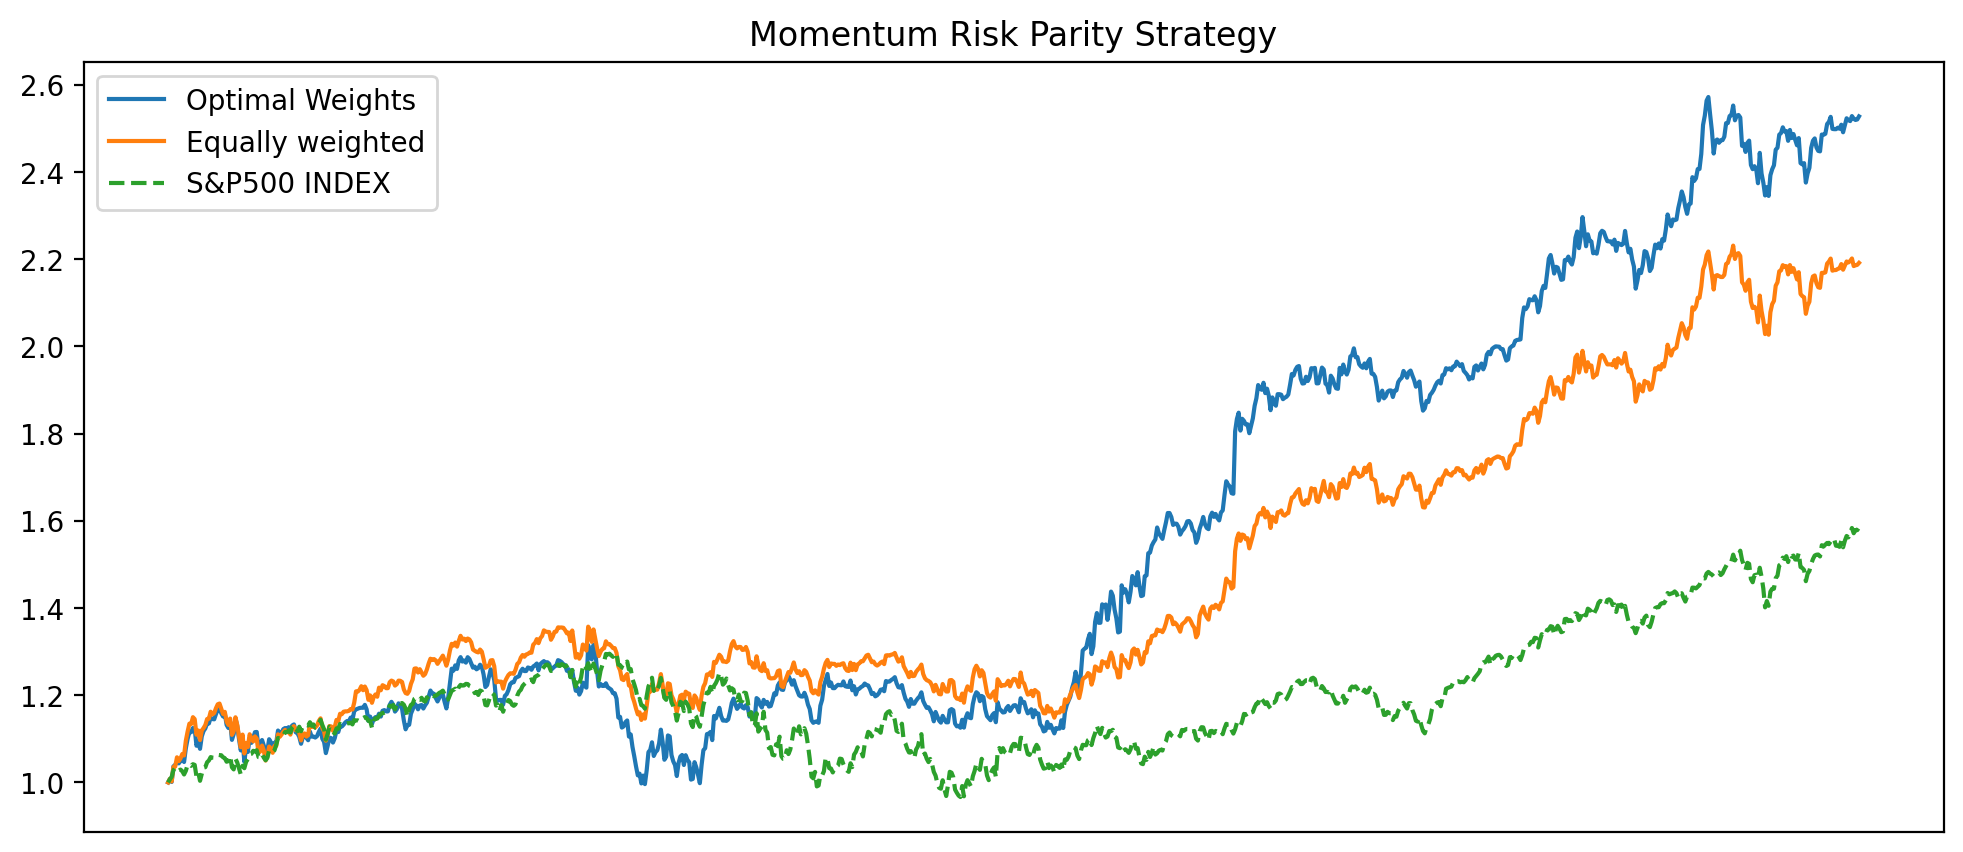

In [463]:
plt.subplots(figsize=(12,5))
report_port = np.array(report_port)
y = report_port#.cumsum()
plt.title('Momentum Risk Parity Strategy')
plt.plot(report_port,label='Optimal Weights')
plt.plot(report_port_eq,label='Equally weighted')

b = df[df['Quarter']!=df['Quarter'].iloc[0]]['SPX']
b = b/b.iloc[0]
plt.plot(b,label='S&P500 INDEX',linestyle='--')
plt.legend()
plt.xticks([])
plt.show()

In [465]:
report_rank()

2020Q4 TSM,AVGO,GOOG,LLY,AAPL,
2021Q1 GOOG,LLY,ORCL,META,AVGO,
2021Q2 NVDA,LLY,GOOG,META,MSFT,
2021Q3 COST,CRM,ORCL,GOOG,MSFT,
2021Q4 NVDA,AVGO,UNH,COST,AAPL,
2022Q1 XAUUSD,MRK,LLY,COST,UNH,
2022Q2 LLY,MRK,UNH,XAUUSD,ORCL,
2022Q3 AMZN,LLY,AAPL,UNH,COST,
2022Q4 ORCL,MRK,AVGO,NVDA,LLY,
2023Q1 NVDA,META,CRM,AAPL,TSM,
2023Q2 NVDA,AVGO,META,LLY,AMZN,
2023Q3 LLY,GOOG,UNH,META,COST,
2023Q4 AVGO,CRM,TSM,AMZN,MSFT,
2024Q1 NVDA,META,TSM,LLY,AVGO,
2024Q2 NVDA,AAPL,TSM,LLY,AVGO,
2024Q3 ORCL,UNH,META,XAUUSD,AAPL,
2024Q4 NVDA,TSM,CRM,AVGO,ORCL,


In [478]:
start_date = '2020-10-01'
stop_date = '2024-10-18' 

df = pd.DataFrame({'eq':report_port})
df.perf_stat(start_date,stop_date,riskFree=0.02)

stat
Max Drawdown -0.242723
CAGR          0.257291
Volatility    0.208942
Shape Ratio   1.180522

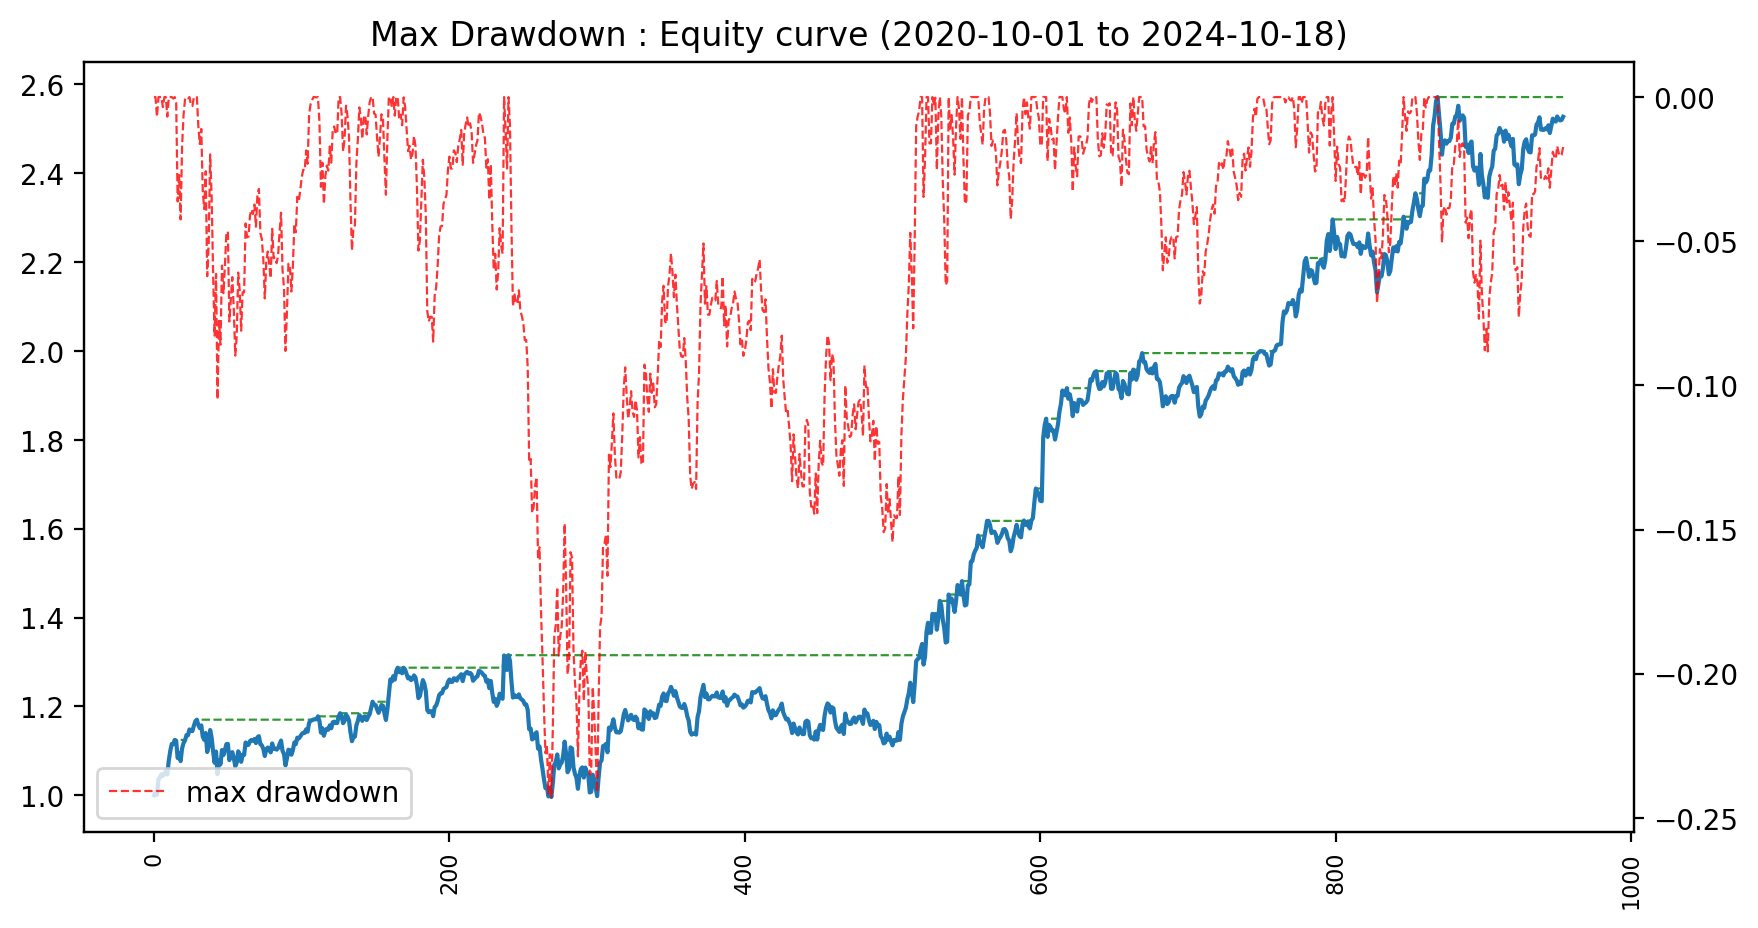

In [484]:
report = df.max_drawdown()

fig , ax1 =  plt.subplots(figsize=(10,5))
ax1.plot(report.index,report['Cumulative Max'],color='green',alpha=0.8,linewidth=0.8,linestyle='--')
ax1.plot(report.index,report['eq'])
plt.xticks(rotation=90,fontsize=8)

ax2 = ax1.twinx()
ax2.plot(report.index,report['Drawdown'],color='red',alpha=0.8,linewidth=0.8,linestyle='--',label='max drawdown')

plt.title(f'Max Drawdown : Equity curve ({start_date} to {stop_date})')
plt.legend()
plt.show()

In [502]:
start_date , stop_date = '2020-10-01' , '2024-10-18' 
# วัดประสิทธิภาพและความเสี่ยงของพอร์ต
df.perf_stat(start_date,stop_date,riskFree=0.02)

stat
Max Drawdown  -0.242723
CAGR           0.257291
Volatility     0.208942
Shape Ratio    1.180522
Sortino Ratio  1.905855

In [508]:
df.CAGR(start_date,stop_date) # ถ้าต้องการแยกส่วน

0.25729102398849846